What we need:
* Introduce longitude and latitude into the data (will make easier for not so apparent transfers)

* Start introducing weighted edges for subway, bus and commuter rail (will worry about ferries later)

* Begin data analysis

In [114]:
import numpy as np
import pandas as pd
import requests
import json
import re
import networkx as nx
import ggplot
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
url = "http://realtime.mbta.com/developer/api/v2/routes"

querystring = {"api_key":"wX9NwuHnZU2ToO7GmGR9uw","format":"json"}

headers = {
    'cache-control': "no-cache",
    'postman-token': "4c7b8b89-58b4-c8f5-2509-0647e1775340"
    }

response = requests.request("GET", url, headers=headers, params=querystring)
routes=response.json()
#Route Types: Subway, Commuter Rail, Bus, Boat
subwayRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Subway']
subwayRouteID=[y for x in subwayRouteID for y in x]
crRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Commuter Rail']
crRouteID=[y for x in crRouteID for y in x]
busRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Bus']
busRouteID=[y for x in busRouteID for y in x]
boatRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Boat']
boatRouteID=[y for x in boatRouteID for y in x]

routesDic={'Subway':{subkey:[] for subkey in subwayRouteID},'Bus':{buskey:[] for buskey in busRouteID},'Commuter Rail':{crkey:[] for crkey in crRouteID},
           'Boat':{boatkey:[] for boatkey in boatRouteID}}

for key in routesDic:
    for route in routesDic[key]:
        url = "http://realtime.mbta.com/developer/api/v2/stopsbyroute"
        querystring = {"api_key":"wX9NwuHnZU2ToO7GmGR9uw","route":route,"format":"json"}
        headers = {
            'cache-control': "no-cache",
            'postman-token': "014e80a3-7552-8a15-6796-afa8e81495f3"
            }
        response = requests.request("GET", url, headers=headers, params=querystring)
        stops=response.json()
        #routesDic[key][route]=[re.sub(r'(.*) - .*',r'\1',x['stop_name']).replace(' Busway','').replace(' Lower','').replace(' Upper','') for x in stops['direction'][0]['stop']]
        routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x['stop_name']).replace(' Busway','').replace(' Lower','').replace(' Upper',''),(float(x['stop_lon']),float(x['stop_lat']))] for x in stops['direction'][0]['stop']]
        if key=='Subway':
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Orange Line',''),x[1]] for x in routesDic[key][route]]
        else:
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Station',''),x[1]] for x in routesDic[key][route] if 'South' not in x and 'North' not in x]
routesDic['Subway']['Red-Ashmont']=routesDic['Subway']['Red'][:12]+routesDic['Subway']['Red'][13:18]
routesDic['Subway']['Red-Braintree']=routesDic['Subway']['Red'][:13]+routesDic['Subway']['Red'][18:]
del routesDic['Subway']['Red']
routesDic


{'Boat': {'Boat-F1': [['Boston (Long Wharf)', (-71.050247, 42.360018)],
   ['Boston (Rowes Wharf)', (-71.049897, 42.355721)],
   ['Logan Airport', (-71.02734, 42.359789)],
   ['Hull', (-70.920215, 42.303251)],
   ['Hingham', (-70.919875, 42.252643)]],
  'Boat-F4': [['Boston (Long Wharf)', (-71.050247, 42.360018)],
   ['Charlestown', (-71.05416, 42.373334)]]},
 'Bus': {'1': [['Dudley', (-71.083887, 42.329789)],
   ['Washington St opp Ruggles St', (-71.082754, 42.330957)],
   ['Washington St @ Melnea Cass Blvd', (-71.081252, 42.332324)],
   ['Melnea Cass Blvd @ Harrison Ave', (-71.079576, 42.332016)],
   ['Albany St opp Randall St', (-71.076237, 42.331591)],
   ['Massachusetts Ave @ Albany St', (-71.073541, 42.333825)],
   ['Massachusetts Ave @ Harrison Ave', (-71.074931, 42.334948)],
   ['Massachusetts Ave @ Washington St', (-71.076956, 42.336621)],
   ['Massachusetts Ave @ Tremont St', (-71.080362, 42.339459)],
   ['Massachusetts Ave @ Columbus Ave', (-71.081617, 42.340606)],
   ['Mass

In [116]:
babyRouteDic={'Subway':{'green':['A','B','P','G'],'red':['P','D']}}
print(babyRouteDic)
stops=[babyRouteDic['Subway'][key] for key in babyRouteDic['Subway']] 
stops=np.unique([y for x in stops for y in x])
adjacencyList={key:[] for key in stops}
for key in babyRouteDic:
    for route in babyRouteDic[key]:
        for i in range(len(babyRouteDic[key][route])):
            if i==0:
                adjacencyList[babyRouteDic[key][route][i]].append(babyRouteDic[key][route][i+1])
            elif i>0 and i<(len(babyRouteDic[key][route])-2):
                adjacencyList[babyRouteDic[key][route][i]].append(babyRouteDic[key][route][i-1])
                adjacencyList[babyRouteDic[key][route][i]].append(babyRouteDic[key][route][i+1])
            else:
                adjacencyList[babyRouteDic[key][route][i]].append(babyRouteDic[key][route][i-1])
adjacencyList

{'Subway': {'red': ['P', 'D'], 'green': ['A', 'B', 'P', 'G']}}


{'A': ['B'], 'B': ['A', 'P'], 'D': ['P'], 'G': ['P'], 'P': ['D', 'B']}

In [117]:
subwayStops=[routesDic['Subway'][key] for key in routesDic['Subway']]
subwayStops=np.unique([y[0] for x in subwayStops for y in x])
subwayAdjacencyList={key:[] for key in subwayStops}
for route in routesDic['Subway']:
    for i in range(len(routesDic['Subway'][route])):
        if i==0:
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        elif i>0 and i<(len(routesDic['Subway'][route])-2):
            if routesDic['Subway'][route][i-1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        else:
            subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            subwayAdjacencyList[routesDic['Subway'][route][i-1][0]].append(routesDic['Subway'][route][i])
subwayAdjacencyList

{'Airport': [['Wood Island', (-71.02286539, 42.3796403)],
  ['Maverick', (-71.03952958, 42.36911856)]],
 'Alewife': [['Davis', (-71.121815, 42.39674)]],
 'Allston Street': [['Griggs Street', (-71.134949, 42.348545)],
  ['Warren Street', (-71.140457, 42.348343)]],
 'Andrew': [['Broadway', (-71.056967, 42.342622)],
  ['JFK/UMASS Braintree', (-71.052391, 42.320685)],
  ['JFK/UMASS Ashmont', (-71.052391, 42.320685)]],
 'Aquarium': [['Maverick', (-71.03952958, 42.36911856)],
  ['State Street', (-71.057598, 42.358978)]],
 'Arlington': [['Boylston', (-71.06459, 42.35302)],
  ['Copley', (-71.077447, 42.349974)]],
 'Ashmont': [['Cedar Grove', (-71.060432, 42.279682)],
  ['Shawmut', (-71.06573796, 42.29312583)]],
 'Assembly': [['Wellington', (-71.077082, 42.40237)],
  ['Sullivan Square', (-71.076994, 42.383975)]],
 'Babcock Street': [['Pleasant Street', (-71.118889, 42.351521)],
  ['Packards Corner', (-71.125031, 42.351967)]],
 'Back Bay': [['Tufts Medical Center', (-71.063917, 42.349662)],
  ['

In [118]:
busStops=[routesDic['Bus'][key] for key in routesDic['Bus']]
busStops=np.unique([y[0] for x in busStops for y in x])
busAdjacencyList={key:[] for key in busStops}
for route in routesDic['Bus']:
    for i in range(len(routesDic['Bus'][route])):
        if i==0:
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        elif i>0 and i<(len(routesDic['Bus'][route])-2):
            if routesDic['Bus'][route][i-1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        else:
            busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            busAdjacencyList[routesDic['Bus'][route][i-1][0]].append(routesDic['Bus'][route][i])
busAdjacencyList

{'326 Mystic Ave': [['Mystic Ave @ Fulbright St', (-71.098132, 42.402252)],
  ['Mystic Ave opp Bonner Ave', (-71.101094, 42.405329)]],
 '88 E Newton St': [['91 E Concord St', (-71.072264, 42.33556)],
  ['Albany St @ E Dedham St', (-71.067875, 42.337556)],
  ['Harrison Ave @ E Newton St', (-71.072162, 42.337402)],
  ['Albany St opp Boston Medical', (-71.07222, 42.33434)],
  ['Harrison Ave @ Worcester Sq', (-71.074011, 42.335883)]],
 'Columbia Rd @ Geneva Ave': [['Columbia Rd @ Devon St',
   (-71.076246, 42.307465)],
  ['Columbia Rd @ Washington St', (-71.080507, 42.305519)]],
 'Washington St @ Lowell St': [['Washington St @ Walnut St',
   (-71.207212, 42.351688)],
  ['Washington St @ Walker St', (-71.212832, 42.350931)]],
 'Pemberton Point': [['Main St from Spring St to Pemberton Pnt (FLAG)',
   (-70.913072, 42.303557)]],
 'Washington St @ Lochdale Rd': [['3867 Washington St opp Tollgate Way',
   (-71.117515, 42.296502)],
  ['Washington St @ Archdale Rd', (-71.121366, 42.292857)],
  ['H

In [119]:
crStops=[routesDic['Commuter Rail'][key] for key in routesDic['Commuter Rail']]
crStops=np.unique([y[0] for x in crStops for y in x])
crAdjacencyList={key:[] for key in crStops}
for route in routesDic['Commuter Rail']:
    for i in range(len(routesDic['Commuter Rail'][route])):
        if i==0:
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        elif i>0 and i<(len(routesDic['Commuter Rail'][route])-2):
            if routesDic['Commuter Rail'][route][i-1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        else:
            crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            crAdjacencyList[routesDic['Commuter Rail'][route][i-1][0]].append(routesDic['Commuter Rail'][route][i])
crAdjacencyList

{'Abington': [['South Weymouth', (-70.953302, 42.155025)],
  ['Whitman', (-70.923411, 42.082749)]],
 'Anderson/Woburn': [['Melrose Highlands', (-71.068297, 42.469464)],
  ['Greenwood', (-71.067247, 42.483005)],
  ['Mishawum', (-71.137618, 42.504402)],
  ['Wilmington', (-71.174334, 42.546624)]],
 'Andover': [['Ballardvale', (-71.159962, 42.627356)],
  ['Lawrence', (-71.15198, 42.701806)]],
 'Ashland': [['Framingham', (-71.416792, 42.276719)],
  ['Southborough', (-71.524371, 42.267024)]],
 'Attleboro': [['Stoughton', (-71.103627, 42.124084)],
  ['South Attleboro', (-71.354621, 41.897943)]],
 'Auburndale': [['West Newton', (-71.230528, 42.347878)],
  ['Wellesley Farms', (-71.272288, 42.323608)]],
 'Ayer': [['Littleton/Rte 495', (-71.502643, 42.519236)],
  ['Shirley', (-71.648004, 42.545089)]],
 'Back Bay': [['South', (-71.05479665, 42.35176309)],
  ['Ruggles', (-71.089189, 42.336505)],
  ['Yawkey', (-71.099974, 42.347581)]],
 'Ballardvale': [['North Wilmington', (-71.159696, 42.569661)],


In [120]:
subwayStopLoc={key[0]:key[1] for key in [y for x in subwayAdjacencyList.values() for y in x]}
busStopLoc={key[0]:key[1] for key in [y for x in busAdjacencyList.values() for y in x]}
crStopLoc={key[0]:key[1] for key in [y for x in crAdjacencyList.values() for y in x]}
subwayStopLoc

{'Airport': (-71.030395, 42.374262),
 'Alewife': (-71.142483, 42.395428),
 'Allston Street': (-71.137955, 42.348701),
 'Andrew': (-71.057655, 42.330154),
 'Aquarium': (-71.051652, 42.359784),
 'Arlington': (-71.070893, 42.351902),
 'Ashmont': (-71.064489, 42.284652),
 'Assembly': (-71.077257, 42.392811),
 'Babcock Street': (-71.12165, 42.35182),
 'Back Bay': (-71.075727, 42.34735),
 'Back of the Hill': (-71.111313, 42.330139),
 'Beachmont': (-70.99231944, 42.39754234),
 'Beaconsfield': (-71.140823, 42.335846),
 'Blandford Street': (-71.100258, 42.349293),
 'Boston College': (-71.166769, 42.340081),
 'Boston Univ Central': (-71.106865, 42.350082),
 'Boston Univ East': (-71.103889, 42.349735),
 'Boston Univ West': (-71.113876, 42.350941),
 'Bowdoin': (-71.062037, 42.361365),
 'Boylston': (-71.06459, 42.35302),
 'Braintree': (-71.0011385, 42.2078543),
 'Brandon Hall': (-71.129082, 42.340023),
 'Brigham Circle': (-71.104609, 42.334229),
 'Broadway': (-71.056967, 42.342622),
 'Brookline Hil

In [121]:
def euclidean_distance(u,v):
    return np.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)


In [122]:
G=nx.MultiGraph()
for stop in subwayStopLoc:
    G.add_node(stop,{'Subway':True,'loc':subwayStopLoc[stop]})
for stop in subwayAdjacencyList:
    for i in range(len(subwayAdjacencyList[stop])): 
        if G.has_edge(stop,subwayAdjacencyList[stop][i][0]) and 'Subway' in G.edge[stop][subwayAdjacencyList[stop][i][0]][0]:
            continue
        else:
            G.add_edge(stop,subwayAdjacencyList[stop][i][0],Subway=True,Distance=euclidean_distance(subwayStopLoc[stop],subwayAdjacencyList[stop][i][1]))
for stop in busStopLoc:
    if stop in G:
        G.node[stop]['Bus']=True
    else:
        G.add_node(stop,{'Bus':True,'loc':busStopLoc[stop]})
for stop in busAdjacencyList:
    for i in range(len(busAdjacencyList[stop])):
        if G.has_edge(stop,busAdjacencyList[stop][i][0]) and 'Bus' in G.edge[stop][busAdjacencyList[stop][i][0]][0]:
            continue
        else:
            G.add_edge(stop,busAdjacencyList[stop][i][0],Bus=True,Distance=euclidean_distance(busStopLoc[stop],busAdjacencyList[stop][i][1]))
for stop in crStopLoc:
    if stop in G:
        G.node[stop]['Commuter Rail']=True
    else:
        G.add_node(stop,{'Commuter Rail':True,'loc':crStopLoc[stop]})
for stop in crAdjacencyList:
        for i in range(len(crAdjacencyList[stop])):
            if G.has_edge(stop,crAdjacencyList[stop][i][0]) and 'Commuter_Rail' in G.edge[stop][crAdjacencyList[stop][i][0]][0]:
                continue
            else:
                G.add_edge(stop,crAdjacencyList[stop][i][0],Commuter_Rail=True,Distance=euclidean_distance(crStopLoc[stop],crAdjacencyList[stop][i][1]))        

In [123]:
print('The number of nodes is: ',len(G.nodes()))
print('The number of links is: ',len(G.edges()))
print('The number of connected components is: ',len(list(nx.connected_components(G))))
print('<k> = ',np.mean(list(G.degree().values())))

The number of nodes is:  4515
The number of links is:  5225
The number of connected components is:  1
<k> =  2.31450719823


     k       p_k
0    2  0.794241
1    3  0.097896
2    4  0.056478
3    1  0.021262
4    5  0.016611
5    6  0.006645
6    7  0.002436
7    9  0.002215
8    8  0.000886
9   14  0.000443
10  10  0.000443
11  23  0.000221
12  11  0.000221


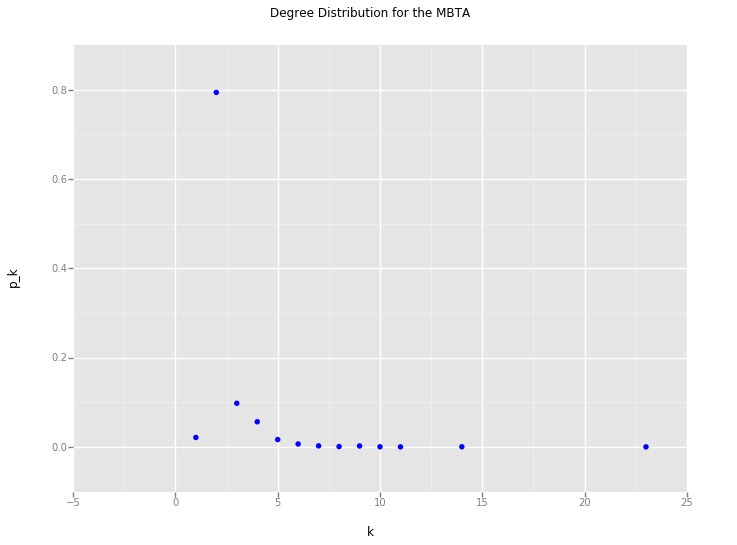

<ggplot: (190330901701)>

In [124]:
degDist=pd.DataFrame(pd.Series(list(G.degree().values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDist.p_k=degDist.p_k/degDist.p_k.sum()
p=ggplot.ggplot(ggplot.aes(x='k',y='p_k'),data=degDist)
print(degDist)
p + ggplot.geom_point(size=30,color='blue') + ggplot.ggtitle('Degree Distribution for the MBTA')